## Годовой проект. 22 группа.
### EDA. Пункт 4, 5 (README.md)

##### Задачи:
- Результаты template mining
- Последовательности шаблонов и примеры подозрительных цепочек.

#### Результаты template mining

Производим первичное преобразование логов

In [1]:
import pandas as pd
import re
import csv

full_log = []
msg = []
param = []
pattern = r":\s"

with open("HDFS.log", "r") as f:
    for line in f:
        part = re.split(pattern, line[:-1], maxsplit=1)
        full_log.append(line[:-1])
        param.append(part[0])
        msg.append(part[1])

df = pd.DataFrame({'full_log': full_log,'param': param,'msg': msg})

param_df = df['param'].str.split(' ',expand=True)
param_df.columns=['date','time','pid','level','component']
df = pd.concat([df,param_df],axis=1)

df.head()

,full_log,param,msg,date,time,pid,level,component
0,081109 203518 143 INFO dfs.DataNode$DataXceive...,081109 203518 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203518,143,INFO,dfs.DataNode$DataXceiver
1,081109 203518 35 INFO dfs.FSNamesystem: BLOCK*...,081109 203518 35 INFO dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,081109,203518,35,INFO,dfs.FSNamesystem
2,081109 203519 143 INFO dfs.DataNode$DataXceive...,081109 203519 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,143,INFO,dfs.DataNode$DataXceiver
3,081109 203519 145 INFO dfs.DataNode$DataXceive...,081109 203519 145 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,145,INFO,dfs.DataNode$DataXceiver
4,081109 203519 145 INFO dfs.DataNode$PacketResp...,081109 203519 145 INFO dfs.DataNode$PacketResp...,PacketResponder 1 for block blk_-1608999687919...,081109,203519,145,INFO,dfs.DataNode$PacketResponder


Получаем словарь регулярных выражений, ключ - тип события, значение - регулярное выражение (темплейт под тип события). 

In [2]:
with open('HDFS_templates_clean.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    templates_dict = {row[0]: row[1] for row in reader}

In [3]:
print(templates_dict)

{'E1': '.*Adding an already existing block.*', 'E2': '.*Verification succeeded for.*', 'E3': '.*Served block.*to.*', 'E4': '.*Got exception while serving.*to.*', 'E5': '.*Receiving block.*src:.*dest:.*', 'E6': '.*Received block.*src:.*dest:.*of size.*', 'E7': '.*writeBlock.*received exception.*', 'E8': '.*PacketResponder.*for block.*Interrupted.*', 'E9': '.*Received block.*of size.*from.*', 'E10': '.*PacketResponder.*Exception.*', 'E11': '.*PacketResponder .* for block .* terminating.*', 'E12': '.*:Exception writing block.*to mirror.*', 'E13': '.*Receiving empty packet for block.*', 'E14': '.*Exception in receiveBlock for block.*', 'E15': '.*Changing block file offset of block.*from.*to.*meta file offset to.*', 'E16': '.*:Transmitted block.*to.*', 'E17': '.*:Failed to transfer.*to.*got.*', 'E18': '.*Starting thread to transfer block.*to.*', 'E19': '.*Reopen Block.*', 'E20': '.*Unexpected error trying to delete block.*BlockInfo not found in volumeMap.*', 'E21': '.*Deleting block.*file.*

Сопоставляем темплейты с нашими логами. Получаем типы событий.

In [4]:
def match_msg_eventid(msg):
    for code, regex in templates_dict.items():
        if re.fullmatch(regex, msg):
            return code

def match_msg_eventid_regex(msg):
    for code, regex in templates_dict.items():
        if re.fullmatch(regex, msg):
            return regex
     
df['EventID'] = df['msg'].apply(match_msg_eventid)
df['EventID_regex'] = df['msg'].apply(match_msg_eventid_regex)

In [5]:
df.head()

,full_log,param,msg,date,time,pid,level,component,EventID,EventID_regex
0,081109 203518 143 INFO dfs.DataNode$DataXceive...,081109 203518 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203518,143,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*
1,081109 203518 35 INFO dfs.FSNamesystem: BLOCK*...,081109 203518 35 INFO dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,081109,203518,35,INFO,dfs.FSNamesystem,E22,.*BLOCK\* NameSystem.*allocateBlock:.*
2,081109 203519 143 INFO dfs.DataNode$DataXceive...,081109 203519 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,143,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*
3,081109 203519 145 INFO dfs.DataNode$DataXceive...,081109 203519 145 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,145,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*
4,081109 203519 145 INFO dfs.DataNode$PacketResp...,081109 203519 145 INFO dfs.DataNode$PacketResp...,PacketResponder 1 for block blk_-1608999687919...,081109,203519,145,INFO,dfs.DataNode$PacketResponder,E11,.*PacketResponder .* for block .* terminating.*


Распределение логов по типам событий:

In [17]:
df['EventID'].value_counts()

EventID
E5     1723232
E26    1719741
E11    1706679
E9     1706514
E21    1402047
E23    1396174
E22     575061
E3      428726
E4      356207
E2      120036
E6        7097
E25       7002
E18       7002
E16       6937
E20       5545
E7        3416
E13       1464
E28       1288
E27        975
E14        155
E10        108
E15         65
E8          49
E29         47
E12         34
E1          10
E17          9
E19          5
E24          4
Name: count, dtype: int64

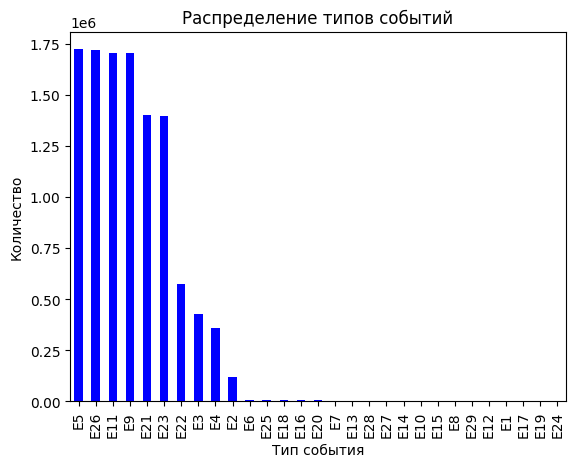

In [10]:
import matplotlib.pyplot as plt

df['EventID'].value_counts().plot(kind='bar', color='blue')

plt.title("Распределение типов событий")
plt.xlabel("Тип события")
plt.ylabel("Количество")
plt.show()

Выделяем наиболее редкие события:

In [13]:
df['EventID'].value_counts().nsmallest(10)

EventID
E24      4
E19      5
E17      9
E1      10
E12     34
E29     47
E8      49
E15     65
E10    108
E14    155
Name: count, dtype: int64

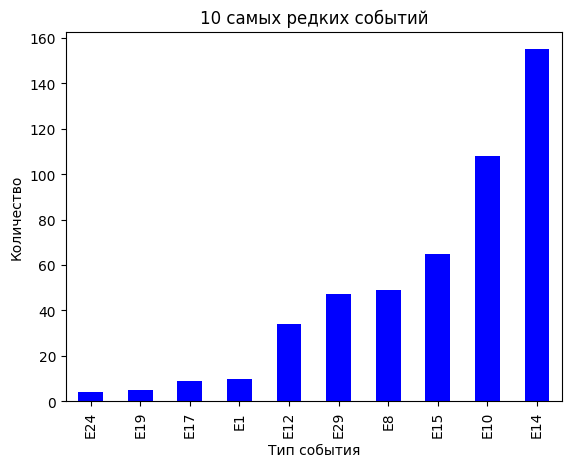

In [15]:
df['EventID'].value_counts().nsmallest(10).plot(kind='bar', color='blue')

plt.title("10 самых редких событий")
plt.xlabel("Тип события")
plt.ylabel("Количество")
plt.show()

In [19]:
df['EventID_regex'].value_counts().nsmallest(10)

EventID_regex
.*BLOCK\* Removing block.*from neededReplications as it does not belong to any file.*      4
.*Reopen Block.*                                                                           5
.*:Failed to transfer.*to.*got.*                                                           9
.*Adding an already existing block.*                                                      10
.*:Exception writing block.*to mirror.*                                                   34
.*PendingReplicationMonitor timed out block.*                                             47
.*PacketResponder.*for block.*Interrupted.*                                               49
.*Changing block file offset of block.*from.*to.*meta file offset to.*                    65
.*PacketResponder.*Exception.*                                                           108
.*Exception in receiveBlock for block.*                                                  155
Name: count, dtype: int64

#### Последовательности шаблонов и примеры подозрительных цепочек.

Выделяем значение блока:

In [20]:
def msg_blk_regex(msg):
    blk = re.findall(r"\s(blk_-?\d+)", msg)
    return blk[0]
     
df['blk'] = df['msg'].apply(msg_blk_regex)

In [21]:
df.head()

,full_log,param,msg,date,time,pid,level,component,EventID,EventID_regex,blk
0,081109 203518 143 INFO dfs.DataNode$DataXceive...,081109 203518 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203518,143,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*,blk_-1608999687919862906
1,081109 203518 35 INFO dfs.FSNamesystem: BLOCK*...,081109 203518 35 INFO dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,081109,203518,35,INFO,dfs.FSNamesystem,E22,.*BLOCK\* NameSystem.*allocateBlock:.*,blk_-1608999687919862906
2,081109 203519 143 INFO dfs.DataNode$DataXceive...,081109 203519 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,143,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*,blk_-1608999687919862906
3,081109 203519 145 INFO dfs.DataNode$DataXceive...,081109 203519 145 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,145,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*,blk_-1608999687919862906
4,081109 203519 145 INFO dfs.DataNode$PacketResp...,081109 203519 145 INFO dfs.DataNode$PacketResp...,PacketResponder 1 for block blk_-1608999687919...,081109,203519,145,INFO,dfs.DataNode$PacketResponder,E11,.*PacketResponder .* for block .* terminating.*,blk_-1608999687919862906


Получаем и помечаем логи на аномальные и нормальные

In [22]:
anomaly = pd.read_csv("anomaly_label.csv")
df_with_anomaly = pd.merge(df, anomaly, left_on = 'blk', right_on = 'BlockId', how = 'left')
df_with_anomaly.head()

,full_log,param,msg,date,time,pid,level,component,EventID,EventID_regex,blk,BlockId,Label
0,081109 203518 143 INFO dfs.DataNode$DataXceive...,081109 203518 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203518,143,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*,blk_-1608999687919862906,blk_-1608999687919862906,Normal
1,081109 203518 35 INFO dfs.FSNamesystem: BLOCK*...,081109 203518 35 INFO dfs.FSNamesystem,BLOCK* NameSystem.allocateBlock: /mnt/hadoop/m...,081109,203518,35,INFO,dfs.FSNamesystem,E22,.*BLOCK\* NameSystem.*allocateBlock:.*,blk_-1608999687919862906,blk_-1608999687919862906,Normal
2,081109 203519 143 INFO dfs.DataNode$DataXceive...,081109 203519 143 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,143,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*,blk_-1608999687919862906,blk_-1608999687919862906,Normal
3,081109 203519 145 INFO dfs.DataNode$DataXceive...,081109 203519 145 INFO dfs.DataNode$DataXceiver,Receiving block blk_-1608999687919862906 src: ...,081109,203519,145,INFO,dfs.DataNode$DataXceiver,E5,.*Receiving block.*src:.*dest:.*,blk_-1608999687919862906,blk_-1608999687919862906,Normal
4,081109 203519 145 INFO dfs.DataNode$PacketResp...,081109 203519 145 INFO dfs.DataNode$PacketResp...,PacketResponder 1 for block blk_-1608999687919...,081109,203519,145,INFO,dfs.DataNode$PacketResponder,E11,.*PacketResponder .* for block .* terminating.*,blk_-1608999687919862906,blk_-1608999687919862906,Normal


Выполняем группировку аномальных логов по BlockId и агрегируем значения EventID. Тем самым получаем последовательность (цепочку) событий для аномальных блоков.

In [23]:
group_anomaly = (df_with_anomaly[df_with_anomaly['Label'] == 'Anomaly'].groupby('BlockId').agg(
        EventID = ('EventID', lambda x: list(x))
    )
)

group_anomaly.head()

,EventID
BlockId,
blk_-1000723577943457888,"[E5, E22, E5, E7]"
blk_-1001299764911418845,"[E5, E5, E5, E22, E11, E9, E26, E11, E9, E11, ..."
blk_-1009207079038502874,"[E22, E5, E5, E5, E26, E26, E11, E9, E11, E9, ..."
blk_-1009284756580063377,"[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11,..."
blk_-101140094574068250,"[E5, E22]"


Топ 10 цепочек событий для аномальных блоков

In [28]:
group_anomaly['EventID'].value_counts().head(10)

EventID
[E5, E22]                                                                                              1643
[E22, E5, E5, E7]                                                                                      1361
[E22, E5]                                                                                              1307
[E5, E5, E22, E7]                                                                                      1252
[E5, E22, E5, E7]                                                                                       612
[E5, E5, E5, E22, E11, E9, E11, E9, E11, E9, E26, E26, E26, E23, E23, E23, E21, E21, E21, E20]          375
[E5, E5, E5, E22, E11, E9, E11, E9, E11, E9, E26, E26, E26, E23, E23, E23, E21, E21, E20, E21]          339
[E5, E5, E5, E22, E11, E9, E11, E9, E11, E9, E26, E26, E26, E23, E23, E23, E21, E20, E21, E21]          322
[E22, E5, E5, E5, E26, E26, E26, E11, E9, E11, E9, E11, E9, E23, E23, E23, E21, E21, E28, E26, E21]     222
[E5, E22, E5, E5, E1